<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from ipywidgets import interact
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from google.colab import drive
from keras import backend as K
from PIL import Image

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [4]:
df[df['dataset']=='refuge'].groupby(['tag']).size()

tag
Glaucoma     40
Normal      360
dtype: int64

# Misc

In [ ]:
H_OD = np.array([])
H_OC = np.array([])
W_OD = np.array([])
W_OC = np.array([])
for i in range(len(df)):
  OD_mask = cv2.imread(df['path_OD_png'][i], 0)
  OC_mask = cv2.imread(df['path_OC_png'][i], 0)
  OD_mask,_ = cv2.findContours(OD_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OC_mask,_ = cv2.findContours(OC_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OD_mask = cv2.approxPolyDP(OD_mask[0], 3, True)
  OC_mask = cv2.approxPolyDP(OC_mask[0], 3, True)
  _, _, w_OD, h_OD = cv2.boundingRect(OD_mask)
  _, _, w_OC, h_OC = cv2.boundingRect(OC_mask)
  H_OD = np.append(H_OD, h_OD)
  H_OC = np.append(H_OC, h_OC)
  W_OD = np.append(W_OD, w_OD)
  W_OC = np.append(W_OC, w_OC)

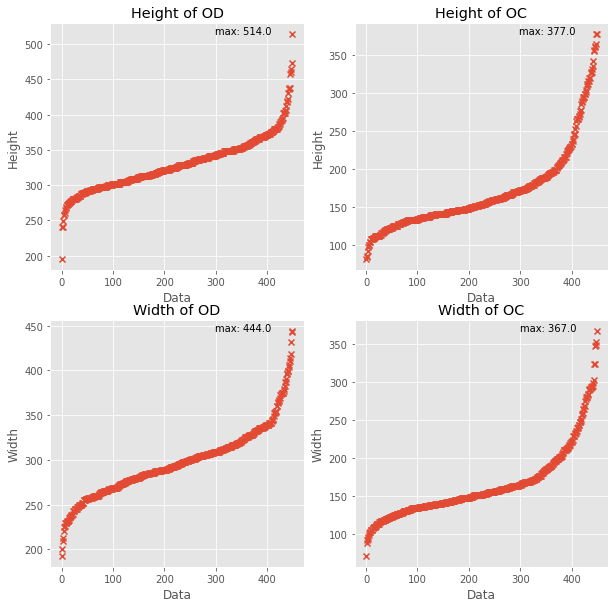

In [ ]:
H_OD = np.sort(H_OD, axis=0)
H_OC = np.sort(H_OC, axis=0)
W_OD = np.sort(W_OD, axis=0)
W_OC = np.sort(W_OC, axis=0)
plt.figure(figsize=(10,10))
plt.subplot(221), 
plt.scatter(list(range(len(df))), H_OD, marker='x')
plt.title('Height of OD')
plt.text(np.argmax(H_OD)-150, np.max(H_OD), 'max: {}'.format(np.max(H_OD)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(222),
plt.scatter(list(range(len(df))), H_OC, marker='x')
plt.title('Height of OC')
plt.text(np.argmax(H_OC)-150, np.max(H_OC), 'max: {}'.format(np.max(H_OC)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(223),
plt.scatter(list(range(len(df))), W_OD, marker='x')
plt.title('Width of OD')
plt.text(np.argmax(W_OD)-150, np.max(W_OD), 'max: {}'.format(np.max(W_OD)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.subplot(224),
plt.scatter(list(range(len(df))), W_OC, marker='x')
plt.title('Width of OC')
plt.text(np.argmax(W_OC)-150, np.max(W_OC), 'max: {}'.format(np.max(W_OC)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.show()

In [ ]:
error_OD = []
error_OC = []
for i in range(len(df)):
  img_OD = cv2.imread(df['path_OD_png'][5], 0)
  img_OD,_ = ekstrakROI(df['disc_center'][5], 550, img_OD)
  img1_OD = img_OD/255.0
  
  img2_OD = downscale(img1_OD)
  img3_OD = upscale(img2_OD)
  #img2_OD = cv2.resize(img1_OD, (256, 256), interpolation = cv2.INTER_CUBIC)
  #img3_OD = cv2.resize(img2_OD, (550, 550), interpolation = cv2.INTER_CUBIC)
  #
  #img3_OD = resize(img2_OD, (550, 550), mode = 'constant', preserve_range = True)
  
  img3_OD = img3_OD>0.5

  img_OC = cv2.imread(df['path_OC_png'][5], 0)
  img_OC,_ = ekstrakROI(df['disc_center'][5], 550, img_OC)
  img1_OC = img_OC/255.0

  img2_OC = downscale(img1_OC)
  img3_OC = upscale(img2_OC)
  #img2_OC = cv2.resize(img1_OC, (256, 256), interpolation = cv2.INTER_CUBIC)
  #img3_OC = cv2.resize(img2_OC, (550, 550), interpolation = cv2.INTER_CUBIC)
  #
  #img3_OC = resize(img2_OC, (550, 550), mode = 'constant', preserve_range = True)
  
  img3_OC = img3_OC>0.5

  DSC_OD = np.sum(img3_OD[img1_OD==1.0])*2.0 / (np.sum(img3_OD) + np.sum(img1_OD))
  DSC_OC = np.sum(img3_OC[img1_OC==1.0])*2.0 / (np.sum(img3_OC) + np.sum(img1_OC))

  error_OD.append(1-DSC_OD)
  error_OC.append(1-DSC_OC)

error_OD = np.array(error_OD)
error_OC = np.array(error_OC)
print('Mean error dari resizing OD: {:.6f}'.format(np.mean(error_OD)))
print('STD error dari resizing OD: {:.6f}'.format(np.std(error_OD)))
print('Mean error dari resizing OC: {:.6f}'.format(np.mean(error_OC)))
print('STD error dari resizing OC: {:.6f}'.format(np.std(error_OC)))

Mean error dari resizing OD: 0.000571
STD error dari resizing OD: 0.000000
Mean error dari resizing OC: 0.000656
STD error dari resizing OC: 0.000000


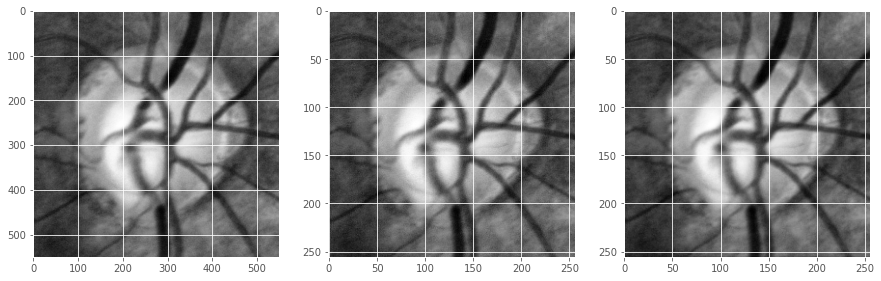

In [ ]:
img = cv2.imread(df['path'][1], 1)[:,:,1]
center = df['disc_center'][1]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
img,_ = ekstrakROI(center, 550, img)
img1 = downscale(img.reshape(550, 550, 1))
img2 = resize(img, (256, 256), mode = 'constant', preserve_range = True)
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.subplot(132), plt.imshow(img1.numpy().squeeze(), cmap='gray')
plt.subplot(133), plt.imshow(img2, cmap='gray')
plt.show()


# Functions

In [5]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)
  dx = (x1 - x0) - s
  dy = (y1 - y0) - s
  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0
    x1 -= dx
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1
    x0 += dx
  else:
    x0 += dx

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0
    y1 -= dy
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)
    y0 += dy
  else:
    y0 += dy

  return y0, y1, x0, x1

In [6]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image

def ekstrakROI(centroid, s, img):
  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
def histo(histories):
  for i, histori in enumerate(histories):
    plt.figure(figsize=(20, 5))
    print('Fold-{}'.format(i+1))
    plt.subplot(131), 
    plt.plot(histori.history["accuracy"], label="accuracy")
    plt.plot(histori.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmax(histori.history["val_accuracy"]), np.max(histori.history["val_accuracy"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(132), 
    plt.plot(histori.history["fscore"], label="fscore")
    plt.plot(histori.history["val_fscore"], label="val_fscore")
    plt.plot( np.argmax(histori.history["val_fscore"]), np.max(histori.history["val_fscore"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Fscore")
    plt.legend()
    plt.subplot(133),
    plt.plot(histori.history["loss"], label="loss")
    plt.plot(histori.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(histori.history["val_loss"]), np.min(histori.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.show()

In [9]:
def downscale(img):
    size = (256, 256)
    img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
    return img

def upscale(img):
  size = (550, 550)
  img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)

  return img

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [20]:
def index_shuffle(X, y, f, random_state=4, test=False):

  ix_dr_gl = np.array(list(range(0, 32)))
  ix_dr_n = np.array(list(range(32, 50)))
  ix_re_gl = np.array(list(range(50, 90)))
  ix_re_n = np.array(list(range(90, 450)))
  print(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)
  print(ix_dr_gl)
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  i = f - 1
  # meta-index for train data
  tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
  tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
  tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
  tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

  # meta-index for test data
  te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
  te_dr_n = list(range(dr_n[i], dr_n[i+1]))
  te_re_gl = list(range(re_gl[i], re_gl[i+1]))
  te_re_n = list(range(re_n[i], re_n[i+1]))

  ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n],
                               ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
  ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n],
                              ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))
  
  print(ix_train)
  random.Random(random_state).shuffle(ix_train)
  random.Random(random_state).shuffle(ix_test)
  print(ix_train)

  X_train = X[ix_train]
  X_test = X[ix_test]
  y_train = y[ix_train]
  y_test = y[ix_test]

  #random.Random(random_state).shuffle(X_train)
  #random.Random(random_state).shuffle(X_test)
  #random.Random(random_state).shuffle(y_train)
  #random.Random(random_state).shuffle(y_test)


  return X_train, X_test, y_train, y_test

In [13]:
def data_shuffle(X, y, f, random_state=4):
  # Mengembablikan data X dan y menjadi data yang siap untuk mentrain dan test model
  # pada fold ke - f
  X_dr_gl = np.array(X[0])
  X_dr_n = np.array(X[1])
  X_re_gl = np.array(X[2])
  X_re_n = np.array(X[3])
  y_dr_gl = np.array(y[0])
  y_dr_n = np.array(y[1])
  y_re_gl = np.array(y[2])
  y_re_n = np.array(y[3])
  #y_dr_glo = np.array(y_ori[0])
  #y_dr_no = np.array(y_ori[1])
  #y_re_glo = np.array(y_ori[2])
  #y_re_no = np.array(y_ori[3])
  random.Random(random_state).shuffle(X_dr_gl)
  random.Random(random_state).shuffle(X_dr_n)
  random.Random(random_state).shuffle(X_re_gl)
  random.Random(random_state).shuffle(X_re_n)
  random.Random(random_state).shuffle(y_dr_gl)
  random.Random(random_state).shuffle(y_dr_n)
  random.Random(random_state).shuffle(y_re_gl)
  random.Random(random_state).shuffle(y_re_n)
  #random.Random(random_state).shuffle(y_dr_glo)
  #random.Random(random_state).shuffle(y_dr_no)
  #random.Random(random_state).shuffle(y_re_glo)
  #random.Random(random_state).shuffle(y_re_no)
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
 
  # index of dataset-label for train data
  tr_dr_gl = list(range(dr_gl[f-1])) + list(range(dr_gl[f], 32))
  tr_dr_n = list(range(dr_n[f-1])) + list(range(dr_n[f], 18))
  tr_re_gl = list(range(re_gl[f-1])) + list(range(re_gl[f], 40))
  tr_re_n = list(range(re_n[f-1])) + list(range(re_n[f], 360))

  # index of dataset-label for test data
  te_dr_gl = list(range(dr_gl[f-1], dr_gl[f])) 
  te_dr_n = list(range(dr_n[f-1], dr_n[f]))
  te_re_gl = list(range(re_gl[f-1], re_gl[f]))
  te_re_n = list(range(re_n[f-1], re_n[f]))

  X_train = np.concatenate((X_dr_gl[tr_dr_gl], X_dr_n[tr_dr_n], 
                            X_re_gl[tr_re_gl], X_re_n[tr_re_n]))
  X_test = np.concatenate((X_dr_gl[te_dr_gl], X_dr_n[te_dr_n], 
                           X_re_gl[te_re_gl], X_re_n[te_re_n]))
  y_train = np.concatenate((y_dr_gl[tr_dr_gl], y_dr_n[tr_dr_n], 
                            y_re_gl[tr_re_gl], y_re_n[tr_re_n]))
  y_test = np.concatenate((y_dr_gl[te_dr_gl], y_dr_n[te_dr_n], 
                           y_re_gl[te_re_gl], y_re_n[te_re_n]))
  #y_test_ori = np.concatenate((y_dr_glo[te_dr_gl], y_dr_no[te_dr_n], 
  #                           y_re_glo[te_re_gl], y_re_no[te_re_n]))
    
  random.Random(random_state).shuffle(X_train)
  random.Random(random_state).shuffle(X_test)
  random.Random(random_state).shuffle(y_train)
  random.Random(random_state).shuffle(y_test)
  #random.Random(random_state).shuffle(y_test_ori)
  dataset = [X_train, X_test, y_train, y_test]
  return dataset

In [14]:
def show_examples(examples, y_examples):
  plt.figure(figsize=(12, 4))
  plt.grid(False)
  for i, example in enumerate(examples):
    h, w = example.shape[:2]
    mask = np.array(example > 0.5, np.uint8)*255
    gt_mask = np.array(y_examples[i] > 0, np.uint8)*255
    DSC = np.sum(mask[gt_mask==255])*2.0 / (np.sum(mask) + np.sum(gt_mask))
    mask = mask.squeeze()
    gt_mask = gt_mask.squeeze()
    mask_show = np.zeros((h, w, 3), np.uint8)
    gt_mask_show = np.zeros((h, w, 3), np.uint8)

    mask_show[:, :, 0] = mask
    gt_mask_show[:, :, 2] = gt_mask
    
    plt.subplot(1, len(examples), i+1),
    plt.imshow(mask_show,  interpolation='none')
    plt.imshow(gt_mask_show, interpolation='none', alpha=0.35)
    plt.text(20, 40, 'DSC: {:.3f}'.format(DSC), fontsize='small', color ='w')

  plt.show()

In [15]:
def k_fold_crossval(X, y, y_ori, callbacks, tipe, k=5, random_state=4, save=0):
  X_dr_gl = np.array(X[0])
  X_dr_n = np.array(X[1])
  X_re_gl = np.array(X[2])
  X_re_n = np.array(X[3])
  y_dr_gl = np.array(y[0])
  y_dr_n = np.array(y[1])
  y_re_gl = np.array(y[2])
  y_re_n = np.array(y[3])
  y_dr_glo = np.array(y_ori[0])
  y_dr_no = np.array(y_ori[1])
  y_re_glo = np.array(y_ori[2])
  y_re_no = np.array(y_ori[3])
  random.Random(random_state).shuffle(X_dr_gl)
  random.Random(random_state).shuffle(X_dr_n)
  random.Random(random_state).shuffle(X_re_gl)
  random.Random(random_state).shuffle(X_re_n)
  random.Random(random_state).shuffle(y_dr_gl)
  random.Random(random_state).shuffle(y_dr_n)
  random.Random(random_state).shuffle(y_re_gl)
  random.Random(random_state).shuffle(y_re_n)
  random.Random(random_state).shuffle(y_dr_glo)
  random.Random(random_state).shuffle(y_dr_no)
  random.Random(random_state).shuffle(y_re_glo)
  random.Random(random_state).shuffle(y_re_no)
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  input_img = Input((256,256, 1), name='img')
  results = []
  fold = []
  Loss = []
  Accuracy = []
  f1score = []
  for i in tqdm_notebook(range(k)):
    # index of dataset-label for train data
    tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
    tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
    tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
    tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

    # index of dataset-label for test data
    te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
    te_dr_n = list(range(dr_n[i], dr_n[i+1]))
    te_re_gl = list(range(re_gl[i], re_gl[i+1]))
    te_re_n = list(range(re_n[i], re_n[i+1]))


    X_train = np.concatenate((X_dr_gl[tr_dr_gl], X_dr_n[tr_dr_n], 
                             X_re_gl[tr_re_gl], X_re_n[tr_re_n]))
    X_test = np.concatenate((X_dr_gl[te_dr_gl], X_dr_n[te_dr_n], 
                             X_re_gl[te_re_gl], X_re_n[te_re_n]))
    y_train = np.concatenate((y_dr_gl[tr_dr_gl], y_dr_n[tr_dr_n], 
                             y_re_gl[tr_re_gl], y_re_n[tr_re_n]))
    y_test = np.concatenate((y_dr_gl[te_dr_gl], y_dr_n[te_dr_n], 
                             y_re_gl[te_re_gl], y_re_n[te_re_n]))
    y_test_ori = np.concatenate((y_dr_glo[te_dr_gl], y_dr_no[te_dr_n], 
                             y_re_glo[te_re_gl], y_re_no[te_re_n]))

    random.Random(random_state).shuffle(X_train)
    random.Random(random_state).shuffle(X_test)
    random.Random(random_state).shuffle(y_train)
    random.Random(random_state).shuffle(y_test)
    random.Random(random_state).shuffle(y_test_ori)

    print('Evaluate fold ', i+1)
    model= get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy",fscore])
    result = model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test), verbose=0)
    
    results.append(result)
    model_layer = model.layers[-1]
    lu = Lambda(upscale, name="lambda_upscale")(model_layer.output)
    model_upscale = Model(model.input, lu, name="upscale_model")
    model_upscale.compile(loss="binary_crossentropy", metrics=["accuracy",fscore])


    los = result.history['val_loss'][-1]
    acc = result.history['val_accuracy'][-1]
    f1 = result.history['val_fscore'][-1]
    los_550, acc_550, f1_550 = model_upscale.evaluate(X_test, y_test_ori, verbose=0)
    idx = list(range(len(y_test_ori)))
    random.Random(3).shuffle(idx)
    idx = idx[:3]
    y_examples = y_test_ori[idx]
    examples = model_upscale.predict(X_test[idx]) 
    if save:
      if los_550 > max(f1score):
        print('Saving best model from fold-', best_fold+1)
        model_upscale.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model {} semantic/'.format(tipe))
        print('Save model success!')
    fold.append(i + 1)
    Loss.append(los_550)
    Accuracy.append(acc_550)
    f1score.append(f1_550)
    print('Fold {}\nloss: {:.4f} - acc: {:.3f} - fscore: {:.3f}'.format(i+1, los, acc, f1))
    print('after upscalling\nloss: {:.4f} - acc: {:.3f} - fscore: {:.3f}'.format(los_550, acc_550, f1_550))
    show_examples(examples, y_examples)

  metrics = pd.DataFrame({'Fold': fold, 'Loss':Loss, 'Acc':Accuracy,
                          'Fscore': f1score})
  best_fold = np.argmax(f1score)
  print('Best model is fold-', best_fold+1)

  return results, metrics

In [16]:
def saving_image(img, path):
  if os.path.isfile(path):
    os.remove(path)
    cv2.imwrite(path, img)
  else:
    cv2.imwrite(path, img)

# Acquiring data

In [21]:
path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Data semantic/"

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC = cv2.imread(df['path_OC_png'][i], 0)

  img,_ = ekstrakROI(center, 550, img)
  gt_OD,_ = ekstrakROI(center, 550, gt_OD)
  gt_OC,_ = ekstrakROI(center, 550, gt_OC)

  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      saving_image(img, path+'drishti/glaucoma/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'drishti/glaucoma/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'drishti/glaucoma/gt/gtOC_{}.png'.format(i+1))
    elif df['tag'][i] == 'Normal':
      saving_image(img, path+'drishti/normal/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'drishti/normal/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'drishti/normal/gt/gtOC_{}.png'.format(i+1))
  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      saving_image(img, path+'refuge/glaucoma/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'refuge/glaucoma/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'refuge/glaucoma/gt/gtOC_{}.png'.format(i+1))
    elif df['tag'][i] == 'Normal':
      saving_image(img, path+'refuge/normal/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'refuge/normal/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'refuge/normal/gt/gtOC_{}.png'.format(i+1))
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# Simple data aquirement
path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Data semantic/"
Xs = []
# X_ori = []
ys_OD = []
ys_OC = []
#y_OD_ori = []
#y_OC_ori = []

for i in tqdm_notebook(range(0, len(df))):  
  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      img_ori = cv2.imread(path+'drishti/glaucoma/image/image_{}.png'.format(i+1), 0).reshape(550, 550, 1)
      gt_OD_ori = cv2.imread(path+'drishti/glaucoma/gt/gtOD_{}.png'.format(i+1), 0).reshape(550, 550, 1)
      gt_OC_ori = cv2.imread(path+'drishti/glaucoma/gt/gtOC_{}.png'.format(i+1), 0).reshape(550, 550, 1)
      # ix_dr_gl.append(i)

    elif df['tag'][i] == 'Normal':
      img_ori = cv2.imread(path+'drishti/normal/image/image_{}.png'.format(i+1), 0).reshape(550, 550, 1) 
      gt_OD_ori = cv2.imread(path+'drishti/normal/gt/gtOD_{}.png'.format(i+1), 0).reshape(550, 550, 1)
      gt_OC_ori = cv2.imread(path+'drishti/normal/gt/gtOC_{}.png'.format(i+1), 0).reshape(550, 550, 1)
      # ix_dr_n.append(i)

  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      img_ori = cv2.imread(path+'refuge/glaucoma/image/image_{}.png'.format(i+1), 0).reshape(550, 550, 1)    
      gt_OD_ori  = cv2.imread(path+'refuge/glaucoma/gt/gtOD_{}.png'.format(i+1), 0).reshape(550, 550, 1) 
      gt_OC_ori  = cv2.imread(path+'refuge/glaucoma/gt/gtOC_{}.png'.format(i+1), 0).reshape(550, 550, 1) 
      # ix_re_gl.append(i)
    elif df['tag'][i] == 'Normal':
      img_ori = cv2.imread(path+'refuge/normal/image/image_{}.png'.format(i+1), 0).reshape(550, 550, 1)    
      gt_OD_ori  = cv2.imread(path+'refuge/normal/gt/gtOD_{}.png'.format(i+1), 0).reshape(550, 550, 1) 
      gt_OC_ori  = cv2.imread(path+'refuge/normal/gt/gtOC_{}.png'.format(i+1), 0).reshape(550, 550, 1) 
      # ix_re_n.append(i)
  
  img = resize(img_ori, (256, 256, 1), mode = 'constant', preserve_range = True)
  gt_OD = resize(gt_OD_ori, (256, 256, 1), mode = 'constant', preserve_range = True)
  gt_OC = resize(gt_OC_ori, (256, 256, 1), mode = 'constant', preserve_range = True)
  # X_ori.append(img_ori/255.0)
  Xs.append(img/255.0)
  #y_OD_ori.append(gt_OD_ori/255.0)
  #y_OC_ori.append(gt_OC_ori/255.0)
  ys_OD.append(gt_OD/255.0)
  ys_OC.append(gt_OC/255.0)


Xs = np.array(Xs)
ys_OD = np.array(ys_OD)
ys_OC = np.array(ys_OC)
#y_OD_ori = np.array(y_OD_ori)
#y_OC_ori = np.array(y_OC_ori)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [23]:
#Eager data acquistion
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
X = []
y_OD_r = []
y_OC_r = []
y_OD = []
y_OC = []

X_dr_gl = []
X_dr_n = []
X_re_gl = []
X_re_n = []
y_dr_gl_OD = []
y_dr_n_OD = []
y_re_gl_OD = []
y_re_n_OD = []
y_dr_gl_OC = []
y_dr_n_OC = []
y_re_gl_OC = []
y_re_n_OC = []

y_dr_glo_OD = []
y_dr_no_OD = []
y_re_glo_OD = []
y_re_no_OD = []
y_dr_glo_OC = []
y_dr_no_OC = []
y_re_glo_OC = []
y_re_no_OC = []

for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD_ori = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC_ori = cv2.imread(df['path_OC_png'][i], 0)

  img,_ = ekstrakROI(center, 550, img)
  gt_OD_ori,_ = ekstrakROI(center, 550, gt_OD_ori)
  gt_OC_ori,_ = ekstrakROI(center, 550, gt_OC_ori)
  img = (resize(img, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD = (resize(gt_OD_ori, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OC = (resize(gt_OC_ori, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD_ori = gt_OD_ori.reshape(550, 550, 1)/255.0
  gt_OC_ori = gt_OC_ori.reshape(550, 550, 1)/255.0
  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      X_dr_gl.append(img)
      y_dr_gl_OD.append(gt_OD)
      y_dr_gl_OC.append(gt_OC)
      # y_dr_glo_OD.append(gt_OD_ori)
      # y_dr_glo_OC.append(gt_OC_ori)
    elif df['tag'][i] == 'Normal':
      X_dr_n.append(img)
      y_dr_n_OD.append(gt_OD)
      y_dr_n_OC.append(gt_OC)
      # y_dr_no_OD.append(gt_OD_ori)
      # y_dr_no_OC.append(gt_OC_ori)
  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      X_re_gl.append(img)
      y_re_gl_OD.append(gt_OD)
      y_re_gl_OC.append(gt_OC)
      # y_re_glo_OD.append(gt_OD_ori)
      # y_re_glo_OC.append(gt_OC_ori)
    elif df['tag'][i] == 'Normal':
      X_re_n.append(img)
      y_re_n_OD.append(gt_OD)
      y_re_n_OC.append(gt_OC)
      # y_re_no_OD.append(gt_OD_ori)
      # y_re_no_OC.append(gt_OC_ori)

X = [X_dr_gl, X_dr_n, X_re_gl, X_re_n]
y_OD = [y_dr_gl_OD, y_dr_n_OD, y_re_gl_OD, y_re_n_OD]
y_OC = [y_dr_gl_OC, y_dr_n_OC, y_re_gl_OC, y_re_n_OC]
# y_OD_ori = [y_dr_glo_OD, y_dr_no_OD, y_re_glo_OD, y_re_no_OD]
# y_OC_ori = [y_dr_glo_OC, y_dr_no_OC, y_re_glo_OC, y_re_no_OC]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: ignored

In [ ]:
# Data splitting for 5 fold validation
dataset_OD = k_fold_cross_data(X, y_OD, k=1, test_size=0.2, random_state=4)
dataset_OC = k_fold_cross_data(X, y_OC, k=1, test_size=0.2, random_state=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
# Simple data splitting
X_train_OD1, X_test_OD1, y_train_OD1, y_test_OD1 = train_test_split(X, y_OD, 
                                                                test_size=0.2, 
                                                                random_state = 5)
X_train_OC1, X_test_OC1, y_train_OC1, y_test_OC1 = train_test_split(X, y_OC, 
                                                                test_size=0.2, 
                                                                random_state = 5)

In [72]:
X_train_OD, X_test_OD, y_train_OD, y_test_OD = data_shuffle(X, y_OD,
                                                            f=1, 
                                                            random_state=4)
X_train_OC, X_test_OC, y_train_OC, y_test_OC = data_shuffle(X, y_OC,
                                                            f=1, 
                                                            random_state=4)

In [73]:
Xs_train_OD, Xs_test_OD, ys_train_OD, ys_test_OD = index_shuffle(Xs, ys_OD, 
                                                                 f=1, 
                                                                 random_state=4, 
                                                                 test=False)
Xs_train_OC, Xs_test_OC, ys_train_OC, ys_test_OC = index_shuffle(Xs, ys_OC, 
                                                                 f=1, 
                                                                 random_state=4, 
                                                                 test=False)

In [74]:
@interact(i = (0, len(df)))
def test(i=0):
  img = X_train_OD[i].squeeze()
  imgs = Xs_train_OD[i].squeeze()
  gt = y_train_OD[i].squeeze()
  gts = ys_train_OD[i].squeeze()
  plt.figure(figsize=(20, 5))
  plt.subplot(1,4,1), plt.imshow(img, cmap='gray')
  plt.subplot(1,4,2), plt.imshow(imgs, cmap='gray')
  plt.subplot(1,4,3), plt.imshow(gt, cmap='gray')
  plt.subplot(1,4,4), plt.imshow(gts, cmap='gray')
  plt.show()

interactive(children=(IntSlider(value=0, description='i', max=450), Output()), _dom_classes=('widget-interact'…

In [ ]:
X_train_OD, X_test_OD, y_train_OD, y_test_OD = dataset_OD[0]
X_train_OC, X_test_OC, y_train_OC, y_test_OC = dataset_OC[0]

# Train and Test

In [ ]:
callbacks_OD = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-OD.h5', mode='max', verbose=1, save_best_only=True, 
                    save_weights_only=True, monitor='val_fscore')
]
callbacks_OC = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-OC.h5', mode='max', verbose=1, save_best_only=True, 
                    save_weights_only=True, monitor='val_fscore')
]

**5 Fold validation**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate fold  1

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Fold 1
loss: 0.0413 - acc: 0.976 - fscore: 0.974
after upscalling
loss: 0.0408 - acc: 0.988 - fscore: 0.976


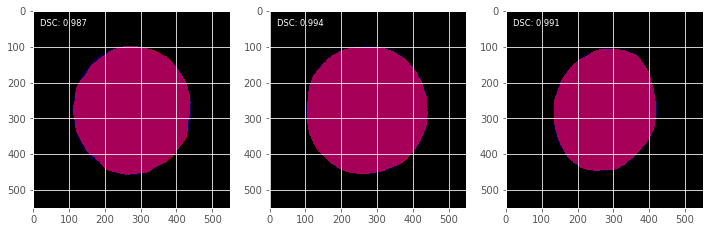

Evaluate fold  2

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00049: early stopping
Fold 2
loss: 0.0837 - acc: 0.968 - fscore: 0.960
after upscalling
loss: 0.0833 - acc: 0.979 - fscore: 0.961


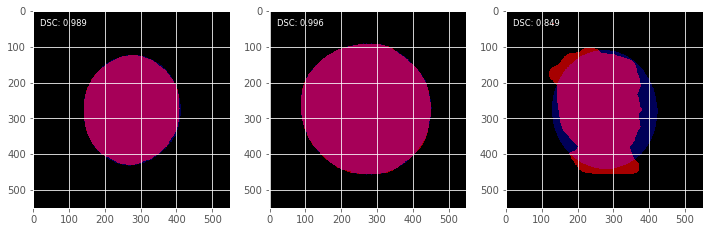

Evaluate fold  3

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 3
loss: 0.0684 - acc: 0.971 - fscore: 0.966
after upscalling
loss: 0.0681 - acc: 0.983 - fscore: 0.968


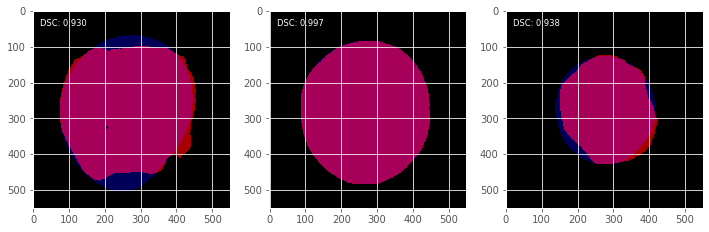

Evaluate fold  4

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 4
loss: 0.0797 - acc: 0.970 - fscore: 0.962
after upscalling
loss: 0.0792 - acc: 0.981 - fscore: 0.965


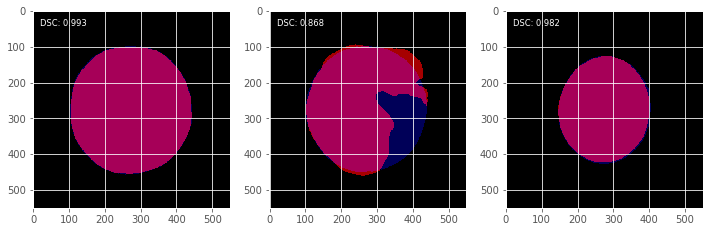

Evaluate fold  5

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00049: early stopping
Fold 5
loss: 0.1302 - acc: 0.959 - fscore: 0.946
after upscalling
loss: 0.1302 - acc: 0.970 - fscore: 0.949


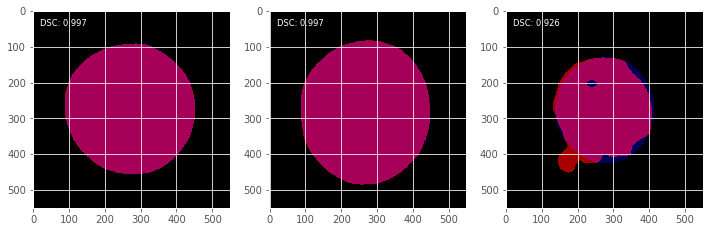


Best model is fold- 1


In [ ]:
results_OD, metrics_OD = k_fold_crossval(X, y_OD, y_OD_ori, callbacks_OD, 'OD', 
                                         k=5, random_state=4, save=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate fold  1
Fold 1
loss: 0.0236 - acc: 0.986 - fscore: 0.961
after upscalling
loss: 0.0233 - acc: 0.993 - fscore: 0.964


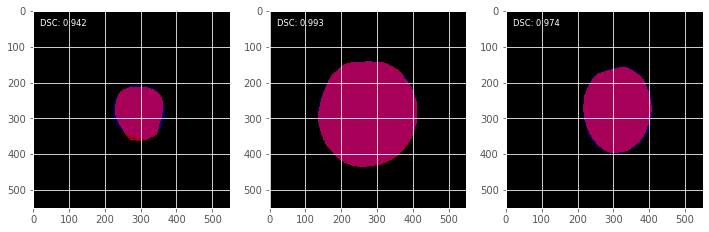

Evaluate fold  2

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 2
loss: 0.0706 - acc: 0.977 - fscore: 0.903
after upscalling
loss: 0.0705 - acc: 0.983 - fscore: 0.904


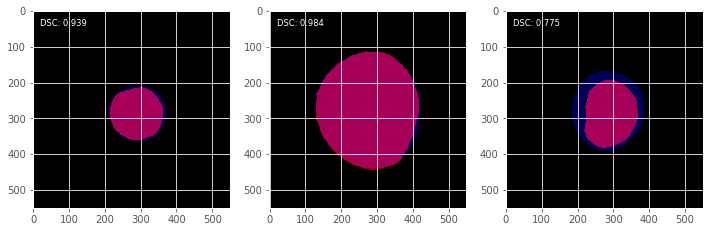

Evaluate fold  3

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 3
loss: 0.0519 - acc: 0.979 - fscore: 0.925
after upscalling
loss: 0.0517 - acc: 0.986 - fscore: 0.929


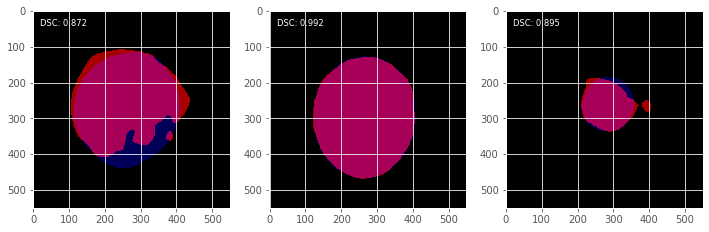

Evaluate fold  4

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Fold 4
loss: 0.0386 - acc: 0.982 - fscore: 0.946
after upscalling
loss: 0.0383 - acc: 0.990 - fscore: 0.951


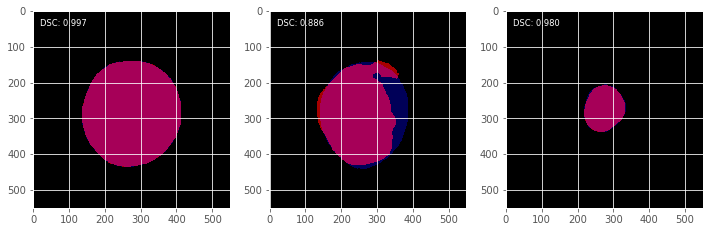

Evaluate fold  5

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 5
loss: 0.0880 - acc: 0.972 - fscore: 0.905
after upscalling
loss: 0.0878 - acc: 0.979 - fscore: 0.909


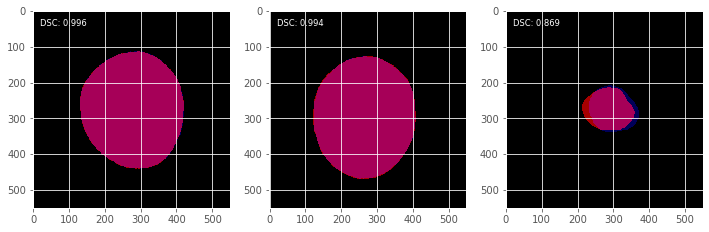


Best model is fold- 1


In [ ]:
results_OC, metrics_OC = k_fold_crossval(X, y_OC, y_OC_ori, callbacks_OC, 'OC',
                                         k=5, random_state=4, save=0)

In [ ]:
metrics_OD.describe()

,Fold,Loss,Acc,Fscore
count,5.000000,5.000000,5.000000,5.000000
mean,3.000000,0.102188,0.959539,0.941592
std,1.581139,0.023762,0.005165,0.006898
min,1.000000,0.077886,0.951435,0.933076
25%,2.000000,0.089413,0.958581,0.936256
50%,3.000000,0.096558,0.959648,0.942365
75%,4.000000,0.106790,0.963898,0.946869
max,5.000000,0.140292,0.964134,0.949395


In [ ]:
metrics_OC.describe()

,Fold,Loss,Acc,Fscore
count,5.000000,5.000000,5.000000,5.000000
mean,3.000000,0.054304,0.986037,0.931483
std,1.581139,0.025547,0.005731,0.025964
min,1.000000,0.023280,0.978686,0.904458
25%,2.000000,0.038259,0.982630,0.908923
50%,3.000000,0.051703,0.985877,0.928931
75%,4.000000,0.070470,0.989747,0.950784
max,5.000000,0.087809,0.993244,0.964318


Fold-1


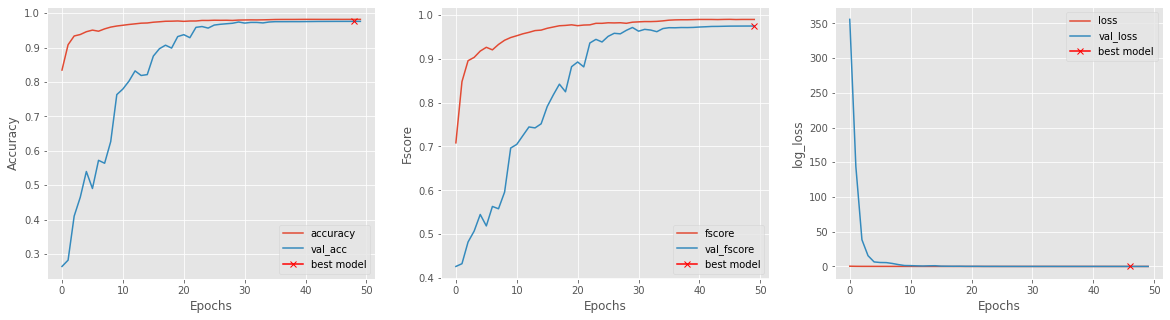

Fold-2


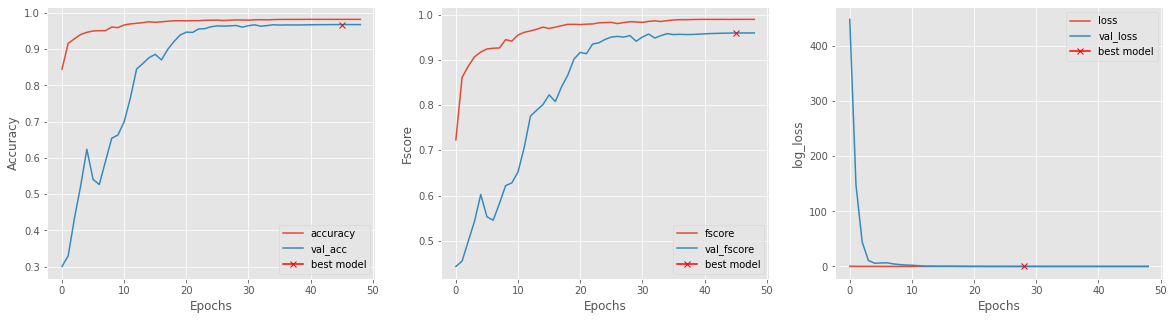

Fold-3


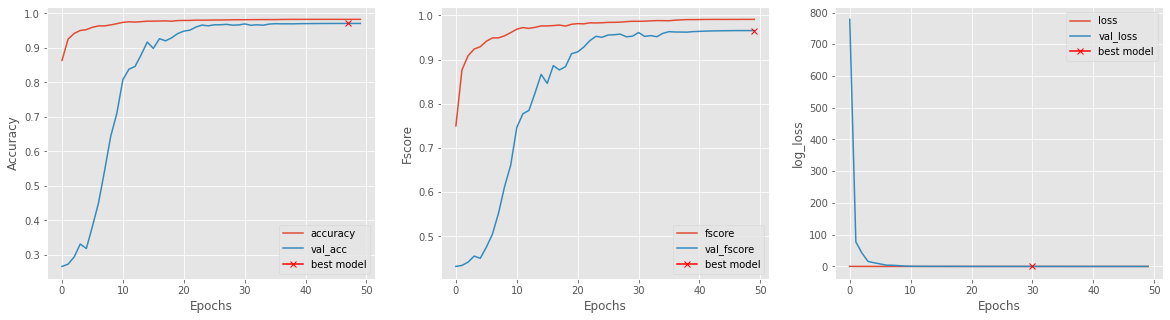

Fold-4


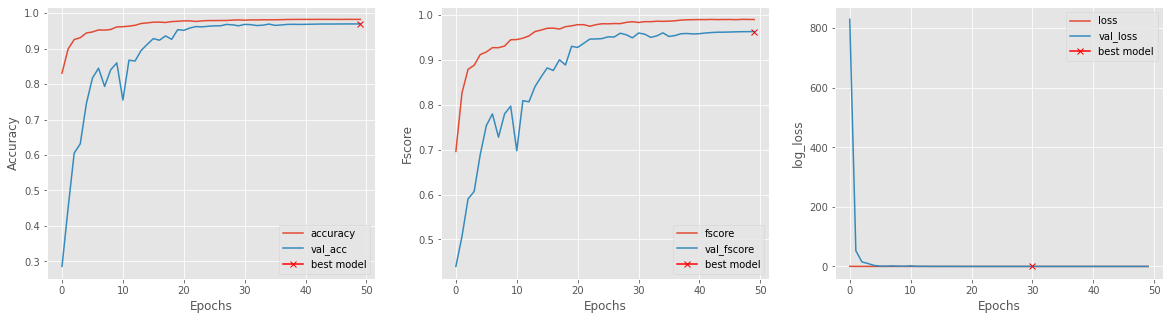

Fold-5


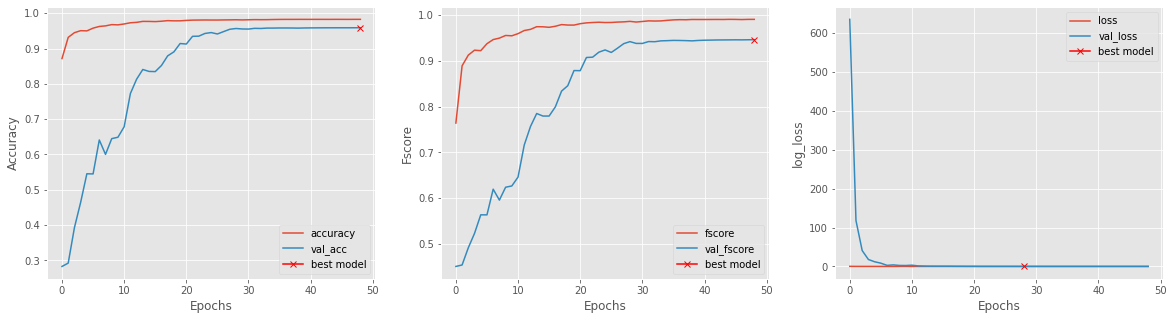

In [ ]:
histo(results_OD)

Fold-1


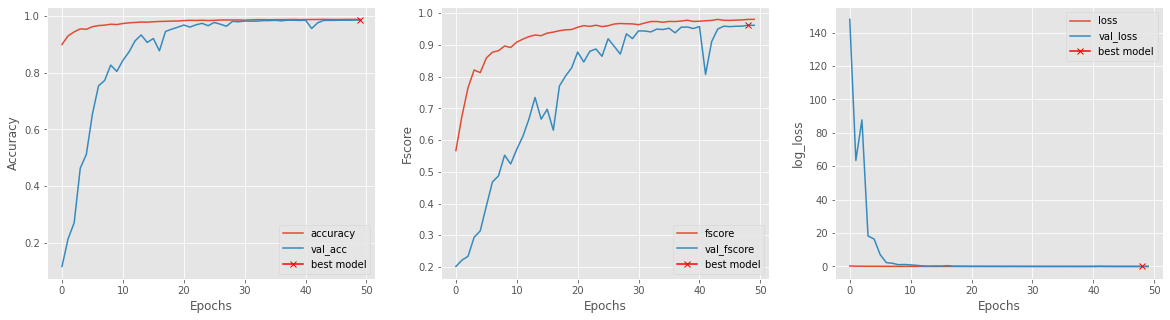

Fold-2


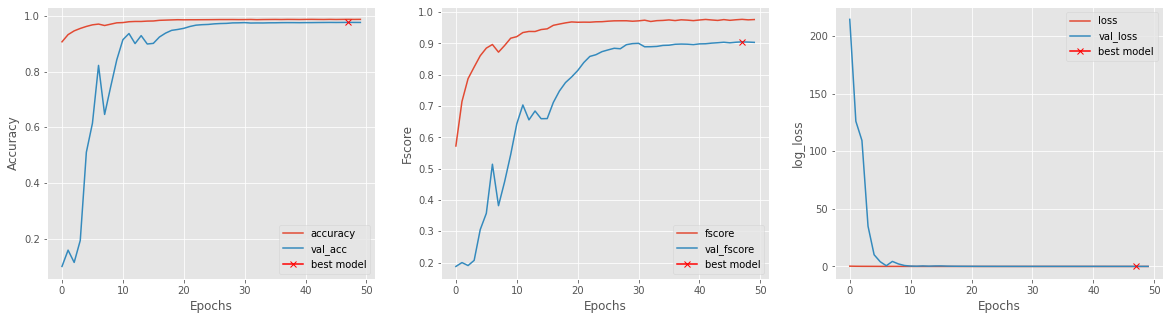

Fold-3


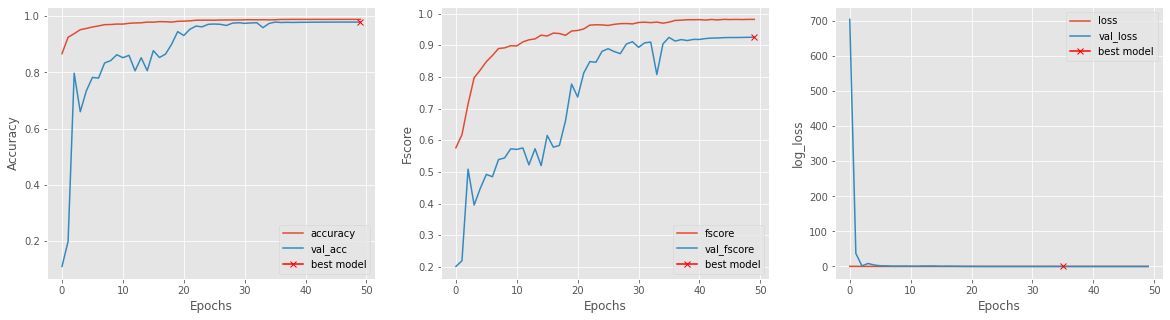

Fold-4


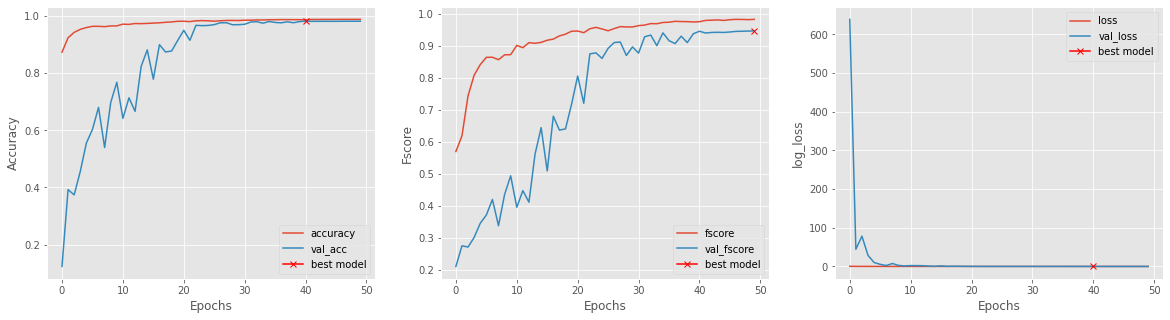

Fold-5


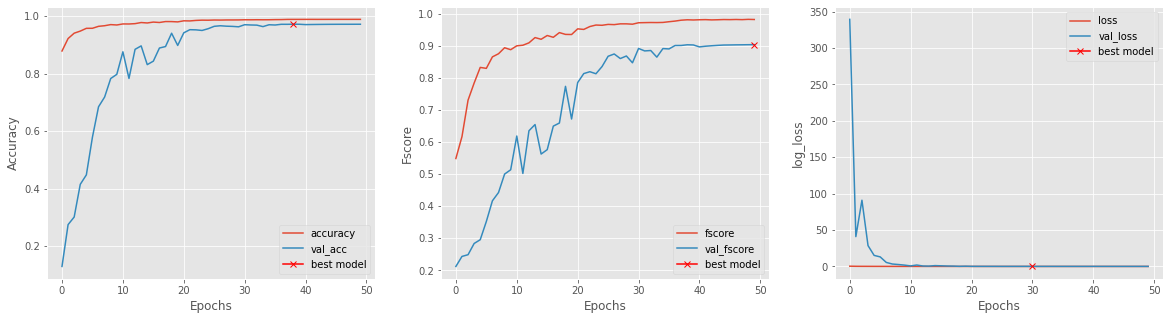

In [ ]:
histo(results_OC)

**Building Model**

In [ ]:
input_img = Input((256, 256, 1), name='img')

In [ ]:
model_OD = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OD.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

model_OC = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OC.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

In [ ]:
model_OD.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 256, 64) 256         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 256, 256, 64) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [ ]:
X_train_OD, X_test_OD, y_train_OD, y_test_OD, y_test_OD_ori = data_shuffle(X, y_OD,
                                                            y_OD_ori,f=1, 
                                                            random_state=4)
X_train_OC, X_test_OC, y_train_OC, y_test_OC, y_test_OC_ori = data_shuffle(X, y_OC,
                                                            y_OC_ori,f=1, 
                                                            random_state=4)

In [ ]:
results_OD = model_OD.fit(X_train_OD, y_train_OD, batch_size=16, epochs=100, callbacks=callbacks_OD,\
                    validation_data=(X_test_OD, y_test_OD))

Epoch 1/100
23/23 [==============================] - 19s 698ms/step - loss: 0.4128 - accuracy: 0.8071 - fscore: 0.6169 - val_loss: 401.2192 - val_accuracy: 0.2747 - val_fscore: 0.4304

Epoch 00001: val_fscore improved from -inf to 0.43041, saving model to model-OD.h5
Epoch 2/100
23/23 [==============================] - 15s 647ms/step - loss: 0.1841 - accuracy: 0.9157 - fscore: 0.8648 - val_loss: 106.0792 - val_accuracy: 0.2909 - val_fscore: 0.4361

Epoch 00002: val_fscore improved from 0.43041 to 0.43608, saving model to model-OD.h5
Epoch 3/100
23/23 [==============================] - 15s 651ms/step - loss: 0.1318 - accuracy: 0.9385 - fscore: 0.9027 - val_loss: 36.1977 - val_accuracy: 0.3291 - val_fscore: 0.4499

Epoch 00003: val_fscore improved from 0.43608 to 0.44989, saving model to model-OD.h5
Epoch 4/100
23/23 [==============================] - 15s 655ms/step - loss: 0.1332 - accuracy: 0.9360 - fscore: 0.8968 - val_loss: 19.1255 - val_accuracy: 0.3908 - val_fscore: 0.4741

Epoch 0

In [ ]:
results_OC = model_OC.fit(X_train_OC, y_train_OC, batch_size=16, epochs=100, callbacks=callbacks_OC,\
                    validation_data=(X_test_OC, y_test_OC))

Epoch 1/100
23/23 [==============================] - 19s 708ms/step - loss: 0.4064 - accuracy: 0.8448 - fscore: 0.5119 - val_loss: 318.9543 - val_accuracy: 0.1124 - val_fscore: 0.2009

Epoch 00001: val_fscore improved from -inf to 0.20086, saving model to model-OC.h5
Epoch 2/100
23/23 [==============================] - 15s 663ms/step - loss: 0.2071 - accuracy: 0.9175 - fscore: 0.5982 - val_loss: 67.6229 - val_accuracy: 0.1714 - val_fscore: 0.2134

Epoch 00002: val_fscore improved from 0.20086 to 0.21337, saving model to model-OC.h5
Epoch 3/100
23/23 [==============================] - 15s 665ms/step - loss: 0.1479 - accuracy: 0.9398 - fscore: 0.7421 - val_loss: 129.4426 - val_accuracy: 0.2850 - val_fscore: 0.2373

Epoch 00003: val_fscore improved from 0.21337 to 0.23725, saving model to model-OC.h5
Epoch 4/100
23/23 [==============================] - 15s 665ms/step - loss: 0.1098 - accuracy: 0.9542 - fscore: 0.8116 - val_loss: 43.5510 - val_accuracy: 0.3863 - val_fscore: 0.2666

Epoch 0

Fold-1


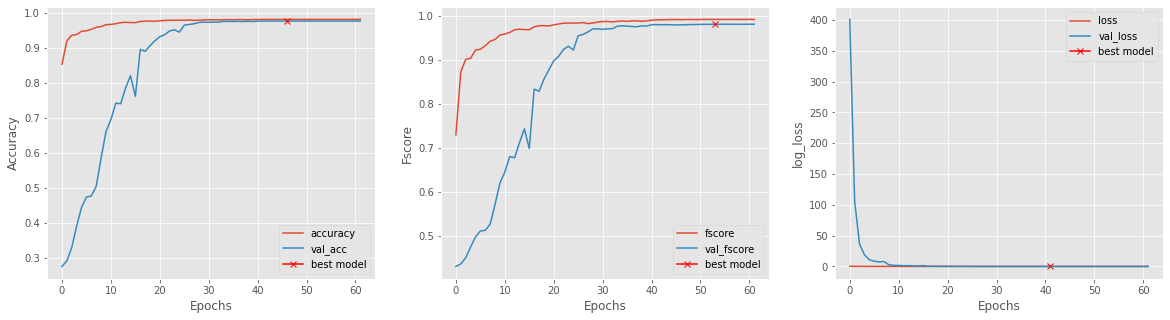

In [ ]:
histo([results_OD])

Fold-1


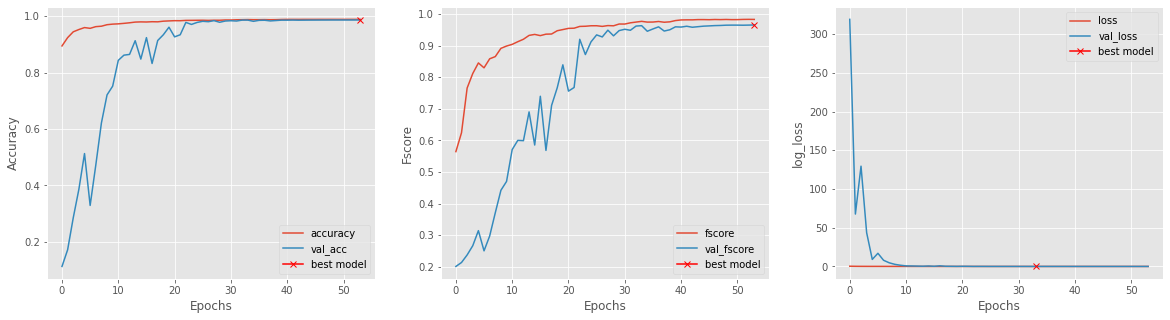

In [ ]:
histo([results_OC])

In [ ]:
# Load the best model
model_OD.load_weights('model-OD.h5')
model_OC.load_weights('model-OC.h5')

In [ ]:
# Adding Lambda layer at the end of model OD and OC
def add_lambda(model, X_test, y_test_ori):    
  model_layer = model.layers[-1]
  lu = Lambda(upscale, name="lambda_upscale")(model_layer.output)
  model_upscale = Model(model.input, lu, name="upscale_model")
  model_upscale.compile(loss="binary_crossentropy", metrics=["accuracy",fscore])
  model_upscale.evaluate(X_test, y_test_ori, verbose=1)
  return model_upscale

In [ ]:
model_OD_up = add_lambda(model_OD, X_test_OD, y_test_OD_ori)
model_OC_up = add_lambda(model_OC, X_test_OC, y_test_OC_ori)

3/3 [==============================] - 3s 381ms/step - loss: 0.2380 - accuracy: 0.9638 - fscore: 0.8419


In [ ]:
model_OD_up.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC_up.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/assets
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/assets


# Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
model_OD_up = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/', custom_objects={'fscore':fscore})
model_OC_up = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/', custom_objects={'fscore':fscore})

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_OD.evaluate(X_test_OD, y_test_OD, verbose=1)
model_OC.evaluate(X_test_OC, y_test_OC, verbose=1)

3/3 [==============================] - 1s 327ms/step - loss: 0.0211 - accuracy: 0.9866 - fscore: 0.9653


[0.02110777050256729, 0.9865792989730835, 0.9652772545814514]

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_OD_up.evaluate(X_test_OD, y_test_OD_ori, verbose=1)
model_OC_up.evaluate(X_test_OC, y_test_OC_ori, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train_OD = model_OD_up.predict(X_train_OD, verbose=1)
preds_val_OD = model_OD_up.predict(X_test_OD, verbose=1)
preds_train_OC = model_OC_up.predict(X_train_OC, verbose=1)
preds_val_OC = model_OC_up.predict(X_test_OC, verbose=1)

3/3 [==============================] - 1s 367ms/step


In [ ]:
# Threshold predictions
preds_train_t_OD = (preds_train_OD > 0.5).astype(np.uint8)
preds_val_t_OD = (preds_val_OD > 0.5).astype(np.uint8)
preds_train_t_OC = (preds_train_OC > 0.5).astype(np.uint8)
preds_val_t_OC = (preds_val_OC > 0.5).astype(np.uint8)

In [ ]:
# Circle Hough Transform Model fitting
def ellipsTransform(mask):
  # Select largest contour
  cnts, _= cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
  elips = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
  if len(cnts)>0:
  # Ellipse fitting
    ellipse = cv2.fitEllipse(cnts[0])
    elips = cv2.ellipse(elips, ellipse, 255, cv2.FILLED)
  else:
    elips = mask
  return elips

In [ ]:
def ellips_fitting(preds):
  ellipsfitted = []
  for mask in preds:
    mask = mask.squeeze()
    mask = ellipsTransform(mask)
    mask = np.expand_dims(mask, axis=-1)
    ellipsfitted.append(mask)
  
  ellipsfitted = np.array(ellipsfitted)
  return ellipsfitted

In [ ]:
# Ellips fitting prediction
pred_val_el_OD = ellips_fitting(preds_val_t_OD)/255.0
pred_val_el_OC = ellips_fitting(preds_val_t_OC)/255.0

In [ ]:
# Mean Fscore calculation
def MeanFscore(pred_val, y_test_ori):
  Fscore = []
  for i, mask in enumerate(pred_val):
    mask = mask.squeeze()
    gt = y_test_ori[i].squeeze()
    DSC = np.sum(mask[gt==1.0])*2 / (np.sum(mask) + np.sum(gt))
    Fscore.append(DSC)

  Fscore = np.array(Fscore)
  mean = np.mean(Fscore)
  std = np.std(Fscore)
  max = np.max(Fscore)
  min = np.min(Fscore)
  print('Mean Fscore: {:.3f} - STD Fscore: {:.3f} - max Fscore: {:.3f} - min Fscore: {:.3f}'.\
        format(mean, std, max, min))

MeanFscore(pred_val_el_OD, y_test_OD_ori)
MeanFscore(pred_val_el_OC, y_test_OC_ori)

Mean Fscore: 0.982 - STD Fscore: 0.028 - max Fscore: 0.997 - min Fscore: 0.876
Mean Fscore: 0.959 - STD Fscore: 0.066 - max Fscore: 0.993 - min Fscore: 0.696


In [ ]:
# Total Fscore calculation
acc_m = tf.keras.metrics.BinaryAccuracy()
loss_m = tf.keras.metrics.BinaryCrossentropy()

acc_m.update_state(pred_val_el_OD, y_test_OD_ori)
loss_m.update_state(pred_val_el_OD, y_test_OD_ori)

acc = acc_m.result().numpy()
f1 = fscore(pred_val_el_OD, y_test_OD_ori)
loss = loss_m.result().numpy()
print('OD segmentation')
print('loss: {:.3f} - accuracy: {:.3f} - fscore: {:.3f}'.format(loss, acc, f1))

acc_m.reset_state()
loss_m.reset_state()

acc_m.update_state(pred_val_el_OC, y_test_OC_ori)
loss_m.update_state(pred_val_el_OC, y_test_OD_ori)
acc = acc_m.result().numpy()
f1 = fscore(pred_val_el_OC, y_test_OC_ori)
loss = loss_m.result().numpy()
print('OC segmentation')
print('loss: {:.3f} - accuracy: {:.3f} - fscore: {:.3f}'.format(loss, acc, f1))

OD segmentation
loss: 0.138 - accuracy: 0.991 - fscore: 0.984
OC segmentation
loss: 2.480 - accuracy: 0.994 - fscore: 0.975


In [ ]:
import scipy.ndimage
import cv2
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');


# Plot image

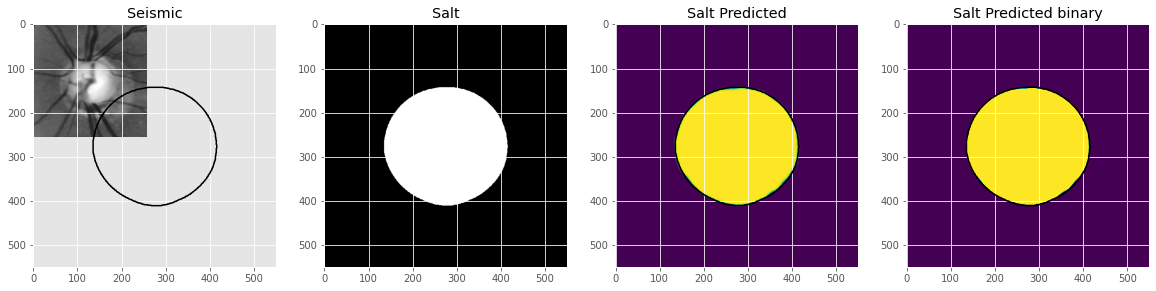

In [ ]:
# Check if training data looks all right
plot_sample(X_test_OD, y_test_OD_ori, preds_val_OD, preds_val_t_OD, ix=30)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=30)

In [ ]:
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=1)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=1)

# Saving model

In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')